In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyrsm as rsm
import seaborn as sns

In [45]:
#Read data 
tuango = pd.read_parquet("data/tuango_pre.parquet")

# Tuango: Targeting Mobile App Push Messages

This file contains information about the test and does not have results about the roll-out. Values for `buyer` and `ordersize` are missing for all customers that were not part of the test.

## Variable Names and Descriptions
* userid: Unique user ID

**Response to the customized push message**
* buyer: Did the customer buy the Karaoke deal? ("yes" or "no")
* ordersize: Number of 30-minute Karaoke sessions the customer purchased

**Recency, Frequency, and Monetary variables**
* recency: Days since last purchase of a deal (before the Karaoke deal offer)
* frequency: Number of deals purchased during the one year period before the Karaoke deal offer
* monetary: Average amount spent per order (in RMB) during the one year period before the Karaoke deal offer

**Other variables in the dataset**
* age: Age of the customer
* gender: Gender identity of the customer (M = male, F = female, O = Other or unknown)
* music: Customer made a purchase in the music category during the one-year period before the Karaoke deal offer ("no" or "yes")
* test: Splits the dataset into test (1) and rollout (0) data
* training: Splits the dataset into training (1) and test (0) data. This variable will not be used in this assignment

In [48]:
#data overview 
tuango.buyer.value_counts(dropna=False)

buyer
NaN    397252
no      18888
yes      2020
Name: count, dtype: int64

In [49]:
tuango.buyer.isna().value_counts()

buyer
True     397252
False     20908
Name: count, dtype: int64

In [50]:
# creating a variable called 'buyer_yes' that has value 1 when buyer == 'yes', has value 0 when buyer == 'no' and has value np.nan when buyer.isna() is True
tuango["buyer_yes"] = tuango["buyer"].map({'yes': 1, 'no': 0})
tuango.buyer_yes.value_counts(dropna=False)

buyer_yes
NaN    397252
0       18888
1        2020
Name: count, dtype: int64

# Preliminary Analysis

What proportion of customers responded to the deal offer message (bought the deal)?

In [51]:

buy = tuango[tuango["buyer_yes"] == 1]
q1 = len(buy)/len(tuango)
q1

0.0048306868184427015


What was the average number of karaoke sessions purchased by customers that bought one or more 30-minute sessions? 


In [52]:
# Creating a calculation code here to create a pd.pivot_table that shows
# (1) counts the number of yes and no, (2) the mean ordersize, and
# (3) the standard deviation in ordersize for yes and no responses
q2 = pd.pivot_table(
    tuango,
    values='ordersize',  
    index='buyer',       
    aggfunc=['count', 'mean', 'std']  
)

q2.loc["yes", "mean"]

/tmp/ipykernel_9583/3616911149.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  q2 = pd.pivot_table(
/tmp/ipykernel_9583/3616911149.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  q2 = pd.pivot_table(
/tmp/ipykernel_9583/3616911149.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  q2 = pd.pivot_table(


ordersize    3.941089
Name: yes, dtype: float64

## Building Targeting Models

Estimating a logistic regression model using “buyer” as the response variable (aka target or dependent variable) and, recency, frequency, monetary, age, gender, and music as the explanatory variables (aka features or independent variables)

In [53]:
clf = 1234
tuango_dummies = pd.get_dummies(tuango, columns=['gender', 'music'], drop_first=True)
tuango_dummies['buyer'] = tuango_dummies['buyer'].astype('object')
tuango_dummies = tuango_dummies.dropna(subset=['buyer']) 
tuango_dummies['buyer'] = tuango_dummies['buyer'].map({'yes': 1, 'no': 0})
tuango_dummies['buyer'].value_counts()
X = tuango_dummies[['recency', 'frequency', 'monetary', 'age', 'gender_F', 'music_yes']]
#creating dummies for logistic regression

In [192]:
#logistic regression
clf = rsm.model.logistic(
    data=tuango, 
    rvar="buyer",  
    lev="yes",  
    evar=[  
        "recency",
        "frequency",
        "monetary",
        "age",
        "gender",  
        "music",
    ],
)

clf.summary()

Logistic regression (GLM)
Data                 : Not provided
Response variable    : buyer
Level                : yes
Explanatory variables: recency, frequency, monetary, age, gender, music
Null hyp.: There is no effect of x on buyer
Alt. hyp.: There is an effect of x on buyer

               OR     OR%  coefficient  std.error  z.value p.value     
Intercept   0.051  -94.9%        -2.98      0.097  -30.768  < .001  ***
gender[F]   1.731   73.1%         0.55      0.054   10.073  < .001  ***
gender[O]   1.078    7.8%         0.07      0.128    0.584   0.559     
music[yes]  1.908   90.8%         0.65      0.059   10.912  < .001  ***
recency     0.999   -0.1%        -0.00      0.000   -3.292  < .001  ***
frequency   1.114   11.4%         0.11      0.010   10.861  < .001  ***
monetary    1.002    0.2%         0.00      0.000   12.499  < .001  ***
age         0.988   -1.2%        -0.01      0.001   -9.115  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R

{'recency': [0.004015289711944481], 'frequency': [0.02295255172753615], 'monetary': [0.024640762797690185], 'age': [0.025920032521041157], 'gender': [0.03395523927392737], 'music': [0.04080848650303402]}


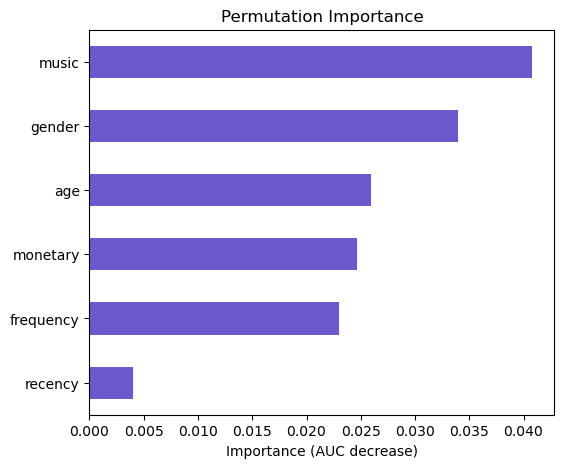

In [80]:
clf.plot("vimp")


Creating Prediction plots for all explanatory variables. Describe the effect of each explanatory variable on the probability that a customer will purchase the karaoke deal

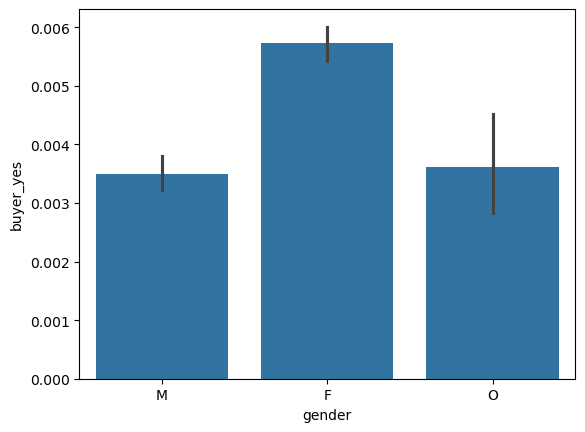

In [63]:
tuango_dummies["buyer_yes"] = rsm.ifelse(tuango_dummies.buyer == "yes", 1, 0)  # no missing values so this works as intended
fig = sns.barplot(data=tuango, x="gender", y="buyer_yes")

In [77]:
mt = tuango_dummies['buyer'].mean()
mt

0.09661373636885402

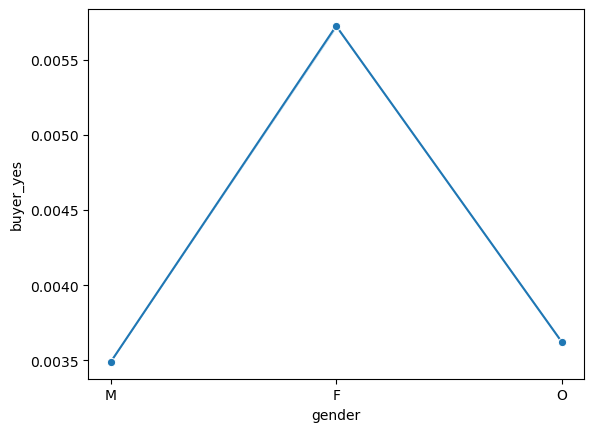

In [71]:
fig = sns.lineplot(data=tuango, x="gender", y="buyer_yes", marker="o", errorbar=("ci", False))

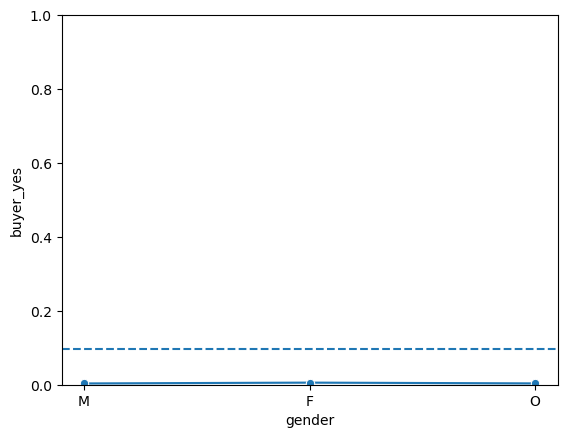

In [76]:
fig = sns.lineplot(data=tuango, x="gender", y="buyer_yes", marker="o", errorbar=("ci", False))
fig = plt.axhline(y=mt, linestyle="--")
fig = plt.ylim(0, 1)

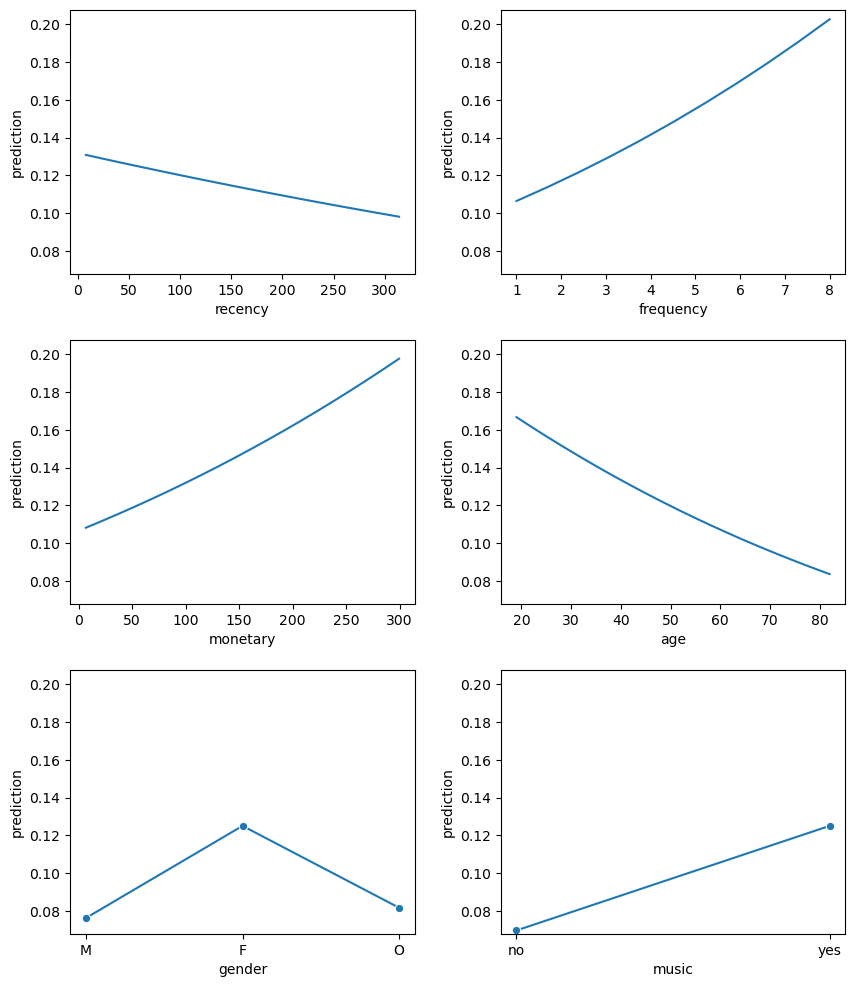

In [83]:
clf.plot("pred")


Using Permutation Importance to assess variable importance. Which variables seem to be most and least important in the model? Explain how Permutation Importance allows you to evaluate variable importance.

{'recency': [0.004015289711944481], 'frequency': [0.02295255172753615], 'monetary': [0.024640762797690185], 'age': [0.025920032521041157], 'gender': [0.03395523927392737], 'music': [0.04080848650303402]}


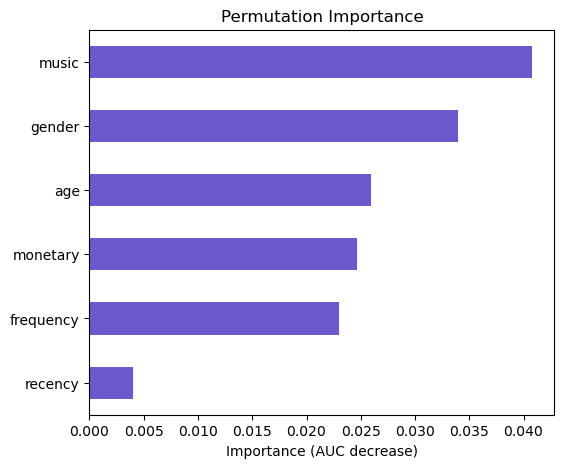

In [81]:
clf.plot("vimp")



Adding the predicted values from the logistic regression to the "tuango" DataFrame. creating variable "pred_logit" as our logistic predictions. Then Comparing the average of the predicted values to the overall response rate ( proportion of buyers).

In [86]:
pred = clf.predict(tuango)

In [89]:
tuango['pred_logit'] = pred['prediction']
tuango['pred_logit'].mean()

0.09659991341853146

In [91]:
mt = tuango_dummies['buyer'].mean()
mt

0.09661373636885402


Estimating a linear regression model using "ordersize" as the response variable and recency, frequency, monetary, age, gender, and music as the explanatory variables. Estimate this regression using only those customers who placed an order after the deal offer message. Describe why you think it does, or does not, make sense to focus on this group of customers

In [94]:
y = tuango['ordersize']

In [97]:
reg = rsm.model.regress(data=tuango_dummies, rvar="ordersize", evar=['recency', 'frequency', 'monetary', 'age', 'gender_F', 'music_yes'])
reg.summary()

Linear regression (OLS)
Data                 : Not provided
Response variable    : ordersize
Explanatory variables: recency, frequency, monetary, age, gender_F, music_yes
Null hyp.: the effect of x on ordersize is zero
Alt. hyp.: the effect of x on ordersize is not zero

           coefficient  std.error  t.value p.value     
Intercept        0.131      0.032    4.057  < .001  ***
recency         -0.000      0.000   -2.919   0.004   **
frequency        0.044      0.004   10.704  < .001  ***
monetary         0.001      0.000   14.953  < .001  ***
age             -0.004      0.000   -8.189  < .001  ***
gender_F         0.179      0.018   10.051  < .001  ***
music_yes        0.194      0.019   10.231  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squared: 0.029, Adjusted R-squared: 0.028
F-statistic: 102.882 df(6, 20901), p.value < 0.001
Nr obs: 20,908


In [102]:
reg = rsm.model.regress(data=tuango, rvar="ordersize", evar=['recency', 'frequency', 'monetary', 'age', 'gender', 'music'])
reg.summary()

Linear regression (OLS)
Data                 : Not provided
Response variable    : ordersize
Explanatory variables: recency, frequency, monetary, age, gender, music
Null hyp.: the effect of x on ordersize is zero
Alt. hyp.: the effect of x on ordersize is not zero

            coefficient  std.error  t.value p.value     
Intercept         0.126      0.033    3.827  < .001  ***
gender[F]         0.184      0.019    9.907  < .001  ***
gender[O]         0.039      0.041    0.943   0.345     
music[yes]        0.195      0.019   10.240  < .001  ***
recency          -0.000      0.000   -2.916   0.004   **
frequency         0.044      0.004   10.712  < .001  ***
monetary          0.001      0.000   14.965  < .001  ***
age              -0.004      0.000   -8.180  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squared: 0.029, Adjusted R-squared: 0.028
F-statistic: 88.311 df(7, 20900), p.value < 0.001
Nr obs: 20,908


### Question 8

Use Permutation Importance to assess variable importance. Which variables seem to be most important in the model?

{'recency': [0.0008250211430758877], 'frequency': [0.009373284274217856], 'monetary': [0.017211235744978008], 'age': [0.005796535537075445], 'gender_F': [0.008367778441937927], 'music_yes': [0.008806811715186673]}


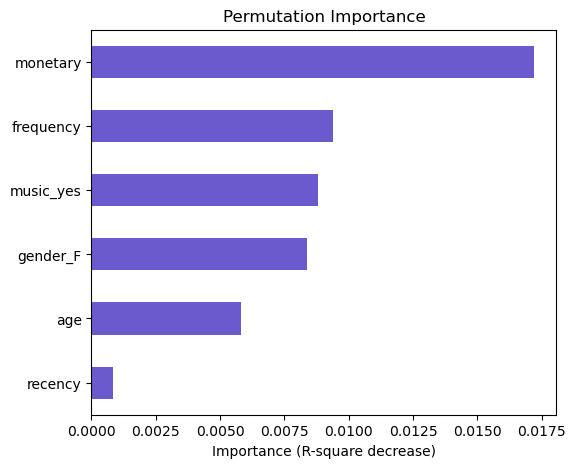

In [98]:
reg.plot("vimp")

Monetary seems to be most important variable



What do the linear regression model results suggest about our ability to predict ordersize for customers who responded to the deal?


The model doesn’t do a great job of predicting ordersize, with an R-squared of just 0.029, meaning it explains only 2.9% of the variance. While some variables, like frequency (0.044) and monetary (0.001), are statistically significant, their effects are tiny. Age has a small negative impact (-0.004), while being female (0.179) or being interested in music (0.194) has a slightly higher impact, but still nothing major. Even though the F-statistic (102.882, p < 0.001) confirms the model is statistically significant overall, the low R-squared shows it doesn’t capture most of what drives ordersize



Adding the predicted values from the linear regression to the "tuango" data.frame and comparing the average of the predicted values to the average value of ordersize. Make sure to focus only on buyers. 

In [103]:
pred2 = reg.predict(tuango)

In [106]:
pred2['prediction'].mean()

0.3806180733639982

In [107]:
tuango['ordersize'].mean()

0.38076334417447866

What I observed

they are almost identical
the model is calibrated in terms of its overall predictions.

##  Profitability Analysis

The following questions focus on the profit and return on marketing expenditures from offering the deal to (some of) the remaining 397,252 potential customers in Hangzhou (i.e., 418,160 – 20,908).

To calculate profit and return on marketing expenditures assume the following:
- Price per 30-minute session is 49 RMB
- Marginal cost of sending a deal offer message is 9 RMB
- Tuango’s fee on each deal sold is 50% of sales revenues


What is the breakeven response rate? 

In [111]:
#calculating breakeven response rate 

cost = 9
margin = 0.5
avg_order = 3.941089
breakeven =  cost / (avg_order * margin * 49 )
q11 = breakeven # float, DO NOT APPLY ROUNDING, do not express as a percentageq11 

0.0932095009210678


Finding the projected profit in RMB and the return on marketing expenditures if we offer the deal to all 397,252 remaining customers (target everyone)

In [114]:
tuango["message_all"] = True

nr_message_all = 397252 # total number of messages that would be sent out
message_cost_all = 9 * nr_message_all# total cost of sending messages to selected customers (float)
nr_responses_all = 0.09659991341853146 * nr_message_all # total number of positive responses
response_rate_all = nr_responses_all/nr_message_all# expressed as a proportion (no rounding)
revenue_all = nr_responses_all * avg_order * margin * 49# total revenue in RMB (no rounding)
profit_all = 0.5 * nr_responses_all * (49 - 9 ) # 0.5 * revenue - message_cost - total profit in RMB (no rounding)
ROME_all = revenue_all/ message_cost_all  # Return on Marketing Expenditures expressed as a proportion (no rounding)

In [115]:
ROME_all

1.0363741084756448

In [113]:
tuango['buyer'].value_counts()

buyer
no     18888
yes     2020
Name: count, dtype: int64

Evaluating the performance implications of offering the deal to only those customers (out of 397,252) with a predicted probability of purchase greater than the breakeven response rate and Determining the projected profit in RMB and the return on marketing expenditures for both approaches.

In [127]:
len(tuango[tuango["test"] == 0])


397252

In [ ]:
high_pred = tuango[tuango['pred_logit'] > breakeven ]
high_pred = high_pred[high_pred['test'] == 0]
high_pred

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test,buyer_yes,pred_logit,pred_bin,message_all
20910,U59772099,NaN,NaN,185,8.0,123.599998,46,O,yes,NaN,0,0,0.134632,8,True
20912,U36020329,NaN,NaN,31,8.0,95.000000,33,F,yes,NaN,0,0,0.244048,9,True
20914,U41061867,NaN,NaN,97,9.0,7.830000,46,F,no,NaN,0,0,0.107997,6,True
20915,U45367432,NaN,NaN,77,9.0,65.000000,52,F,no,NaN,0,0,0.116449,7,True
20919,U72456768,NaN,NaN,12,2.0,120.000000,78,F,yes,NaN,0,0,0.094480,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418152,U86443367,NaN,NaN,135,2.0,31.870000,27,F,yes,NaN,0,0,0.122552,7,True
418154,U68362853,NaN,NaN,21,2.0,19.900000,58,F,yes,NaN,0,0,0.094248,5,True
418155,U83013842,NaN,NaN,19,4.0,128.000000,25,F,yes,NaN,0,0,0.202410,9,True
418156,U45426448,NaN,NaN,131,2.0,110.740000,20,O,yes,NaN,0,0,0.103399,6,True


In [129]:
non_rollouts = len(high_pred)

In [130]:
rollouts = len(tuango[tuango['test']==1])
rollouts

20908

In [154]:
tuango["message_logit"] = tuango.apply(tuple, axis=1).isin(high_pred.apply(tuple, axis=1))


nr_message_logit = non_rollouts # total number of messages that would be sent out
message_cost_logit = 9 * nr_message_logit# total cost of sending messages to selected customers (float)
nr_responses_logit =  0.09659991341853146 * nr_message_logit # total number of positive responses
response_rate_logit = nr_responses_logit/nr_message_logit# expressed as a proportion (no rounding)
revenue_logit = nr_responses_logit * avg_order * margin * 4# total revenue in RMB (no rounding)
profit_logit =  0.5 * nr_responses_logit * (49 - 9 )# 0.5 * revenue - message_cost - total profit in RMB (no rounding)
ROME_logit = revenue_logit/message_cost_logit# Return on Marketing Expenditures expressed as a proportion (no rounding)

In [142]:
ROME_logit

0.08460196803882816

In [143]:
profit_logit/nr_message_logit

1.9319982683706292

In [144]:
profit_all/nr_message_all

1.9319982683706294

Comparing targeted and bulk messaging apporaches 

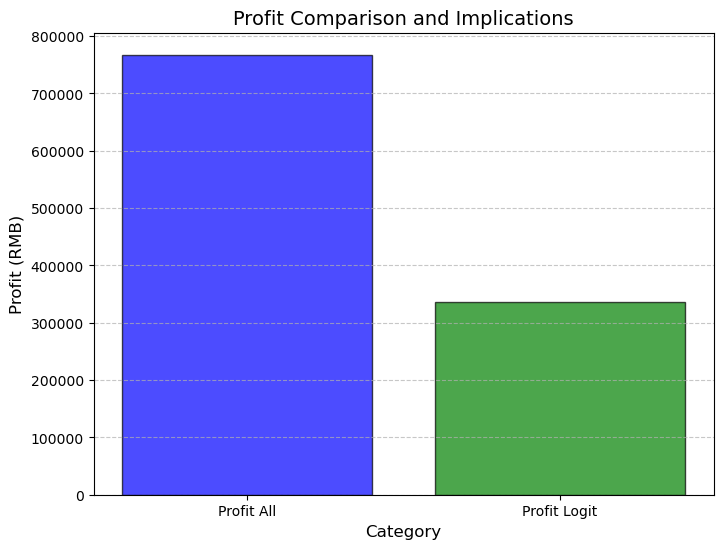

In [145]:
categories = ['Profit All', 'Profit Logit']
profits = [profit_all, profit_logit]
plt.figure(figsize=(8, 6))
plt.bar(categories, profits, color=['blue', 'green'], alpha=0.7, edgecolor='black')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Profit (RMB)', fontsize=12)
plt.title('Profit Comparison and Implications', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid lines for readability
plt.show()

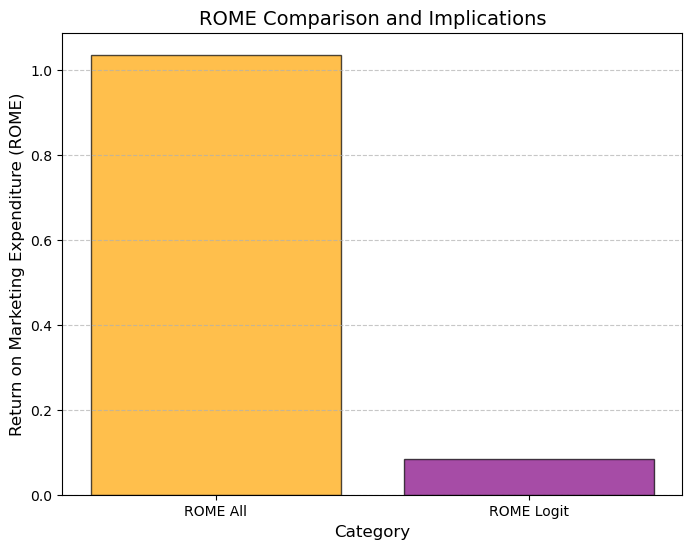

In [146]:
categories = ['ROME All', 'ROME Logit']
rome_values = [ROME_all, ROME_logit]

# Creating the bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, rome_values, color=['orange', 'purple'], alpha=0.7, edgecolor='black')

plt.xlabel('Category', fontsize=12)
plt.ylabel('Return on Marketing Expenditure (ROME)', fontsize=12)
plt.title('ROME Comparison and Implications', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()